In [1]:
import os
import time
import langchain
from langchain.chains import RetrievalQAWithSourcesChain
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from langchain_community.document_loaders import WebBaseLoader
from createvector import VectorStore
from dotenv import load_dotenv
import matplotlib.pyplot as plt 

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
load_dotenv()  # take environment variables from .env (especially openai api key)

vs = VectorStore()# Global variable
vectorstore = None

In [3]:
def update_vectorstore():
    global vectorstore
    loader = WebBaseLoader([
    "https://realpython.com/python-data-science/",
    #"https://realpython.com/primer-on-python-decorators/",
    "https://peps.python.org/"
])
    print("Data Loading...Started...✅✅✅")
    data = loader.load()

    # Split data
    text_splitter = RecursiveCharacterTextSplitter(
        separators=['\n\n', '\n', '.', ','],
        chunk_size=1000,
        chunk_overlap=50
    )
    print("Text Splitter...Started...✅✅✅")
    docs = text_splitter.split_documents(data)
 
    # Create embeddings and save to ChromaDB
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/msmarco-MiniLM-L-12-v3")
    global vectorstore
    # Assign the Chroma object to vectorstore
    vectorstore = vs.loadVectorStore(docs, embeddings)  
    print(vectorstore)
    if vectorstore is None:
        print("VectorStore has not been initialized. Please process the URLs first.>>process_url_clicked>>main.py")
    else:
        print(vectorstore)
    print("Embedding Vector Started Building...✅✅✅")
    

# Call the function to update vectorstore
update_vectorstore()

Data Loading...Started...✅✅✅
Text Splitter...Started...✅✅✅
Adding to collection
Vector store loaded successfully
Embedding Vector Started Building...✅✅✅


In [4]:
def ask_question(query):
    llm = ChatGroq(temperature=1, groq_api_key=os.environ["GROQ_API_KEY"], model_name="llama-3.1-70b-versatile")
    chain = RetrievalQAWithSourcesChain.from_llm(llm=llm, retriever=vectorstore.as_retriever())
    result = chain.invoke({"question": query}, return_only_outputs=True)
    return result 

In [5]:
 test_data = [
    {
        "question": "What is PEP in Python?",
        "expected_answer": "PEP stands for Python Enhancement Proposal. It is a design document providing information to the Python community or describing new features or processes for Python.",
        "relevant_sources": ["https://peps.python.org/"]
    },
    {
        "question": "What are functions in python?",
        "expected_answer": "Python functions are blocks of code that run only when they are called, programmed to return a specific task. They can take values called parameters and are helpful in performing repetitive tasks. The main types of functions in Python include built-in functions, user-defined functions, lambda functions, and recursive functions.",
        "relevant_sources": ["https://www.geeksforgeeks.org/python-functions/"]
    },
    {
        "question": "What are Python decorators?",
        "expected_answer": "Decorators in Python are functions that modify the behavior of other functions or methods. They are applied using the '@' syntax above a function definition.",
        "relevant_sources": ["https://realpython.com/primer-on-python-decorators/"]
    }
]


In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

def evaluate_retrieval(true_sources, predicted_sources):
    """Calculate precision, recall, and F1-score for retrieval."""
    true_labels = [1 if source in true_sources else 0 for source in predicted_sources]
    predicted_labels = [1] * len(predicted_sources)  # All predicted sources are considered relevant
    precision = precision_score(true_labels, predicted_labels,zero_division=0)
    recall = recall_score(true_labels, predicted_labels,zero_division=1)
    f1 = f1_score(true_labels, predicted_labels,zero_division=1)

    return precision, recall, f1

def evaluate_answer(expected_answer, generated_answer):
    """Calculate BLEU and ROUGE scores for generated answers."""
    # BLEU score
    bleu_score = sentence_bleu([expected_answer.split()], generated_answer.split())

    # ROUGE scores
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    rouge_scores = scorer.score(expected_answer, generated_answer)
    #display rouge_scores for each ts
    print({"rouge_scores":rouge_scores})
    return bleu_score, rouge_scores

def measure_latency(func, ques):
    """Measure response latency for a function."""
    start_time = time.time()
    result = func(ques)
    latency = time.time() - start_time
    print(ques)
    print(result)
    return latency, result

In [7]:
def countdown(sec):
    """Counts down from the given number of seconds and prints each second."""
    print(f"Wait period of {sec} seconds to make another llm call.")  
    for i in range(sec, 0, -1):  # Start at `sec`, end at 1, decrement by 1
        time.sleep(1)  # Wait for 1 second


In [8]:

def evaluate_bot(test_data):
    """Evaluate the QA bot on a test dataset."""
    retrieval_metrics = []
    answer_metrics = []
    latencies = []
    predicted_sources=[]
    relevant_sources=[]
    test_num=1
    for test_case in test_data:
        
        print({"test_num":test_num})
        test_num = test_num+1
        question = test_case["question"]
        expected_answer = test_case["expected_answer"]
        relevant_source = test_case["relevant_sources"]#for current test case
        relevant_sources.extend(relevant_source)#for cummulative test cases ran till current iteration
        # Measure latency and get response
        latency, res = measure_latency(ask_question, question)
        print({"relevant_sources":relevant_sources})
       # print({"Latency":latency})
        latencies.append(round(latency, 1))
        
        

#         # Evaluate retrieval
        source = res.get("sources", [])
        #print({"predicted_source":predicted_source})
        predicted_source=[]
        predicted_source.append(source)#for current test case
       # print({"predictedSources":predicted_sources})
        retrieval_metrics.append(
            evaluate_retrieval(relevant_source, predicted_source)
        )

         # Evaluate answer quality
        generated_answer = res["answer"]
        answer_metrics.append(
            evaluate_answer(expected_answer, generated_answer)
       )
    

    # Aggregate results
    avg_latency = sum(latencies) / len(latencies)
    avg_precision = sum([m[0] for m in retrieval_metrics]) / len(retrieval_metrics)
    avg_recall = sum([m[1] for m in retrieval_metrics]) / len(retrieval_metrics)
    avg_f1 = sum([m[2] for m in retrieval_metrics]) / len(retrieval_metrics)
    avg_bleu = sum([m[0] for m in answer_metrics]) / len(answer_metrics)

    print("Evaluation Results:")
    print(f"Average Latency: {avg_latency:.2f}s")
    print(f"Average Retrieval - Average Precision: {avg_precision:.2f},Average Recall: {avg_recall:.2f}, Average F1: {avg_f1:.2f}")
    print(f"Answer Quality - BLEU: {avg_bleu:.2f}")
    # Call the function with the defined data
    plot_metrics(latencies, retrieval_metrics)
    return latencies, retrieval_metrics

In [9]:
def plot_metrics(latencies, retrieval_metrics):
    """Plot evaluation metrics."""
    plt.figure(figsize=(10, 5))  # Create a figure with specified size
    
    # Plot Latencies Histogram
    plt.subplot(1, 2, 1)  # Create a subplot (1 row, 2 columns, 1st position)
    plt.hist(latencies, bins=10, color='blue', alpha=0.7)  # Plot histogram of latencies
    plt.title("Response Latencies")  # Title of the plot
    plt.xlabel("Latency (s)")  # X-axis label
    plt.ylabel("Frequency")  # Y-axis label
    
    # Plot Precision, Recall, F1
    precisions = [m[0] for m in retrieval_metrics]  # Extract precision values
    recalls = [m[1] for m in retrieval_metrics]  # Extract recall values
    f1_scores = [m[2] for m in retrieval_metrics]  # Extract F1-score values
    plt.subplot(1, 2, 2)  # Create a subplot (1 row, 2 columns, 2nd position)
    plt.plot(precisions, label="Avg Precision", marker='o')  # Plot precision
    plt.plot(recalls, label="Avg Recall", marker='o')  # Plot recall
    plt.plot(f1_scores, label="Avg F1-Score", marker='o')  # Plot F1-score
    plt.title("Average Retrieval Metrics")  # Title of the plot
    plt.xlabel("Test Cases")  # X-axis label
    plt.ylabel("Score")  # Y-axis label
    plt.legend()  # Add a legend
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display the plots

   

{'test_num': 1}


Token indices sequence length is longer than the specified maximum sequence length for this model (2020 > 1024). Running this sequence through the model will result in indexing errors


What is PEP in Python?
{'answer': 'PEP stands for Python Enhancement Proposal, which is a document that proposes a new feature or modification to the Python language, standard library, or development process.\n', 'sources': 'https://peps.python.org/'}
{'relevant_sources': ['https://peps.python.org/']}
{'rouge_scores': {'rouge1': Score(precision=0.6538461538461539, recall=0.68, fmeasure=0.6666666666666666), 'rouge2': Score(precision=0.4, recall=0.4166666666666667, fmeasure=0.4081632653061225), 'rougeL': Score(precision=0.5384615384615384, recall=0.56, fmeasure=0.5490196078431373)}}
{'test_num': 2}
What are functions in python?
{'answer': "I don't know what functions in Python are based on the provided text.\n", 'sources': 'https://peps.python.org/'}
{'relevant_sources': ['https://peps.python.org/', 'https://www.geeksforgeeks.org/python-functions/']}
{'rouge_scores': {'rouge1': Score(precision=0.35714285714285715, recall=0.09803921568627451, fmeasure=0.15384615384615385), 'rouge2': Score

/opt/conda/envs/playground-conda-env/lib/python3.11/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


What are Python decorators?
{'answer': "I don't know what Python decorators are based on the provided text.\n", 'sources': 'https://peps.python.org/'}
{'relevant_sources': ['https://peps.python.org/', 'https://www.geeksforgeeks.org/python-functions/', 'https://realpython.com/primer-on-python-decorators/']}
{'rouge_scores': {'rouge1': Score(precision=0.3076923076923077, recall=0.16666666666666666, fmeasure=0.21621621621621623), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.23076923076923078, recall=0.125, fmeasure=0.16216216216216217)}}
Evaluation Results:
Average Latency: 12.27s
Average Retrieval - Average Precision: 0.33,Average Recall: 1.00, Average F1: 0.33
Answer Quality - BLEU: 0.07


/opt/conda/envs/playground-conda-env/lib/python3.11/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/envs/playground-conda-env/lib/python3.11/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/envs/playground-conda-env/lib/python3.11/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.


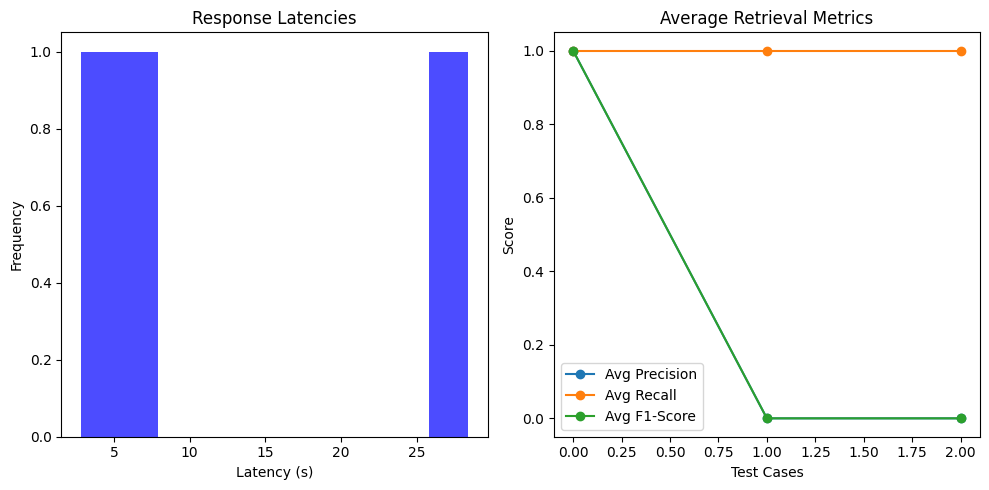

In [10]:
pm=evaluate_bot(test_data)

In [11]:
latencies, retrieval_metrics=pm

In [12]:
latencies

[2.8, 5.6, 28.4]

In [13]:
retrieval_metrics

[(1.0, 1.0, 1.0), (0.0, 1.0, 0.0), (0.0, 1.0, 0.0)]